<a href="https://colab.research.google.com/github/SMTorg/smt-explainability/blob/master/tutorial/Explainability_tools.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Surrogate based explainability tools with SMT

<div class="jumbotron text-left"><b>
The French Aerospace Lab ONERA <br/>
Information Processing and Systems Department (DTIS) <br/>
Multidisciplinary Methods, Integrated Concepts (M2CI) Research Unit <br/>
</div>

Paul Saves ONERA/DTIS
   
**Latest update:** Octover 2024 - `SMT version 2.7.0`

In this notebook, we present an example in order to use conformal prediction within the Toolbox SMT

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link: https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>


**Reference work by Sebastien Da Veiga** *Tutorial on conformal prediction & related methods* https://sites.google.com/view/sebastien-da-veiga/etics-2024-tutorial-on-conformal-prediction-related-methods, 

**Reference work by Daffa Robani et al** *SMT-EX: An Explainable Surrogate Modeling Toolbox for
Mixed-Variables Design Exploration* 

# A mixed cantilever beam problem


The next engineering application is the beam bending problem in the linear elasticity range that features continuous and categorical variables, as shown in Fig. The beam is subjected to a force $F$ applied to the free end. The Young modulus and the load were set to $E=200$ GPa and $F=50$  kN, respectively. The problem features two continuous variables, namely, the length $L \in [10,20]$ (in $m$) and the surface $S \in[1,2]$ (in $m^{2}$). Meanwhile, the categorical variable is the type of cross-section with 12 levels , each associated with the normalized moment of inertia $\tilde{I}$ about the neutral axis.  For the square-shaped cross-section, B is more hollow than A, and C is more hollow than B. This pattern is consistent for the other shapes as well. The output of interest is the tip deflection at the free end, which reads as
\begin{equation}
    \label{eq:cantilever}
    \delta = f(L,S,\tilde{I}) = \frac{F}{3E} \frac{L^{3}}{S^{2}\tilde{I}}.
\end{equation}

In [1]:
from smt.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
import seaborn as sns
from smt.kernels import PowExp, Constant
import pandas as pd
from smt_ex.problems import MixedCantileverBeam
from smt_ex.shap import ShapFeatureImportanceDisplay
from smt.surrogate_models import KRG
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt_ex.shap import ShapDisplay
import numpy as np
from smt.surrogate_models import MixIntKernelType
import matplotlib.pyplot as plt

%matplotlib inline 

nsamples = int(250 * 0.8)
fun = MixedCantileverBeam()
ds = DesignSpace(
    [
        CategoricalVariable(values=[str(i + 1) for i in range(12)]),
        FloatVariable(10.0, 20.0),
        FloatVariable(1.0, 2.0),
    ]
)
x = fun.sample(nsamples)
y = fun(x)


# Index for categorical features
categorical_feature_indices = [0]

is_categorical = [False] * x.shape[1]
for feature_idx in categorical_feature_indices:
    is_categorical[feature_idx] = True

feature_names = [r"$\tilde{I}$", r"$L$", r"$S$"]

In [2]:
model = MixedIntegerKrigingModel(
    surrogate=KRG(
        design_space=ds,
        categorical_kernel=MixIntKernelType.GOWER,
        theta0=[1e-1],
        hyper_opt="Cobyla",
        corr="squar_exp",
        n_start=20,
        print_global=False,
        eval_noise=True,
    ),
)
model.set_training_values(x, np.array(y))
model.train()

In [3]:
x2 = fun.sample(int(250))

y2 = model.predict_values(x2)
# estimated variance
s2 = np.sqrt(model.predict_variances(x2))

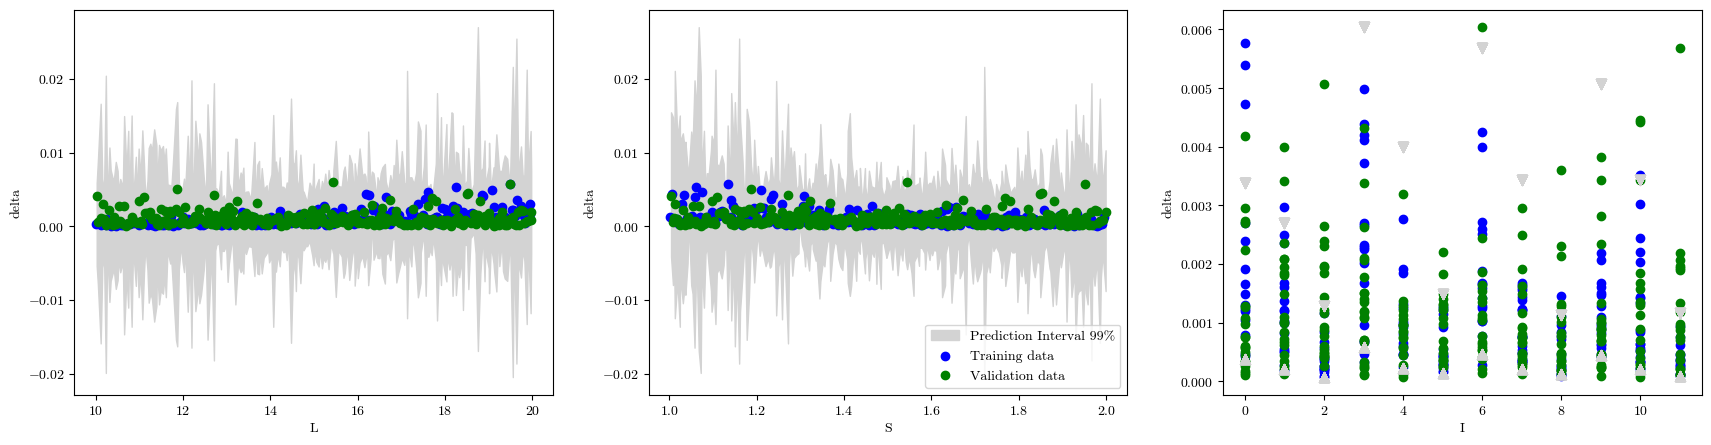

<Figure size 640x480 with 0 Axes>

In [4]:
_, axs = plt.subplots(1, 3, figsize=(21, 5))

# add a plot with variance
# Sort x2 based on the values in the second column
sorted_indices = np.argsort(x2[:, 1])

# Apply the sorted indices to x2 and y2
x2_sorted = x2[sorted_indices]
y2_sorted = y2[sorted_indices]
s2_sorted = s2[sorted_indices]
axs[0].fill_between(
    np.ravel(x2_sorted[:, 1]),
    np.ravel(y2_sorted - 3 * np.sqrt(s2_sorted)),
    np.ravel(y2_sorted + 3 * np.sqrt(s2_sorted)),
    color="lightgray",
)

axs[0].scatter(x[:, 1], y, color="b")
axs[0].scatter(x2_sorted[:, 1], y2, color="g")

axs[0].set_xlabel("L")
axs[0].set_ylabel("delta")

# add a plot with variance
# Sort x2 based on the values in the second column
sorted_indices = np.argsort(x2[:, 2])

# Apply the sorted indices to x2 and y2
x2_sorted = x2[sorted_indices]
y2_sorted = y2[sorted_indices]
s2_sorted = s2[sorted_indices]


# add a plot with variance

axs[1].fill_between(
    np.ravel(x2_sorted[:, 2]),
    np.ravel(y2_sorted - 3 * np.sqrt(s2_sorted)),
    np.ravel(y2_sorted + 3 * np.sqrt(s2_sorted)),
    color="lightgray",
)
axs[1].scatter(x[:, 2], y, color="b")
axs[1].scatter(x2_sorted[:, 2], y2, color="g")

axs[1].set_xlabel("S")
axs[1].set_ylabel("delta")
axs[1].legend(
    ["Prediction Interval 99%", "Training data", "Validation data"],
    loc="lower right",
)


# add a plot with variance
# Sort x2 based on the values in the second column
sorted_indices = np.argsort(x2[:, 0])

# Apply the sorted indices to x2 and y2
x2_sorted = x2[sorted_indices]
y2_sorted = y2[sorted_indices]
s2_sorted = s2[sorted_indices]


# add a plot with variance
axs[2].scatter(x[:, 0], y, color="b")
axs[2].scatter(x2_sorted[:, 0], y2, color="g")
up = np.copy(np.ravel(y2_sorted + 3 * np.sqrt(s2_sorted)))
lo = np.copy(np.ravel(y2_sorted - 3 * np.sqrt(s2_sorted)))

for i in range(len(up)):
    up[i] = np.max(y2_sorted[x2_sorted[:, 0] == x2_sorted[i, 0]])
    lo[i] = np.min(y2_sorted[x2_sorted[:, 0] == x2_sorted[i, 0]])

axs[2].scatter(x2_sorted[:, 0], up, marker="v", s=50, color="lightgray")
axs[2].scatter(x2_sorted[:, 0], lo, marker="^", s=50, color="lightgray")

axs[2].set_xlabel("I")
axs[2].set_ylabel("delta")


plt.show()

plt.savefig("a")

# Conformal and prediction intervals with GP
First, we present an example in order to use conformal prediction within the Toolbox SMT

In [5]:
# Quantile functions
def quantile_cp(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.ceil((1 - alpha) * (n + 1)) - 1)]
    return q


def quantile_cp_minus(z, alpha):
    n = len(z)
    q = np.sort(z)[int(np.floor(alpha * (n + 1)) - 1)]
    return q

### Data generation

In [6]:
x3 = fun.sample(int(250))
y3 = model.predict_values(x2)

sorted_indices = np.argsort(x[:, 1])
x1 = x[:, 1]
train_data = pd.DataFrame({"x": x1[sorted_indices], "y": y[sorted_indices]})
sorted_indices = np.argsort(x2[:, 1])
x21 = x2[:, 1]
y2 = y2[:, 0]
test_data = pd.DataFrame({"x": x21[sorted_indices], "y": y2[sorted_indices]})
sorted_indices = np.argsort(x3[:, 1])
x31 = x3[:, 1]
y3 = y3[:, 0]

visu_data = pd.DataFrame({"x": x31[sorted_indices], "y": y3[sorted_indices]})

In [7]:
# Sample split
ncal = 100
ntrain = 250
npretrain = ntrain - ncal
train_data = train_data.sample(frac=1).reset_index(drop=True)
pretrain_data = train_data.iloc[:npretrain]
cal_data = train_data.iloc[npretrain:]

alpha = 0.1

In [8]:
k = PowExp([0.01]) * Constant([0.01])


gp = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)

# Pretraining Gaussian Process
X_pretrain = pretrain_data["x"].values.reshape(-1, 1)
y_pretrain = pretrain_data["y"].values
gp.set_training_values(X_pretrain, y_pretrain)
gp.train()
gp_pred_pretrain = gp.predict_values(X_pretrain)[:, 0]
gp_std_pretrain = np.sqrt(gp.predict_variances(X_pretrain))[:, 0]

# Compute residuals and fit another GP on residuals
res_gp_pred_pretrain = np.abs(y_pretrain - gp_pred_pretrain)
gp_res = KRG(corr="squar_exp", noise0=[1e-6], hyper_opt="Cobyla", n_start=20)
gp_res.set_training_values(X_pretrain, res_gp_pred_pretrain)
gp_res.train()

# Predictions on calibration data
X_cal = cal_data["x"].values.reshape(-1, 1)
y_cal = cal_data["y"].values
gp_pred_cal = gp.predict_values(X_cal)[:, 0]
gp_std_cal = np.sqrt(gp.predict_variances(X_cal))[:, 0]
gp_res_pred_cal = gp_res.predict_values(X_cal)[:, 0]

res_gp_pred_cal = np.abs(y_cal - gp_pred_cal) / gp_res_pred_cal
gp_q_cal = quantile_cp(res_gp_pred_cal, alpha)

# Predictions for visualization data
X_visu = visu_data["x"].values.reshape(-1, 1)
gp_pred_visu = gp.predict_values(X_visu)[:, 0]
gp_std_visu = np.sqrt(gp.predict_variances(X_visu))[:, 0]
gp_res_pred_visu = gp_res.predict_values(X_visu)[:, 0]

# Compute lower and upper bounds for the GP with rescaling based on residuals
gp_pred = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu,
        ".pred_lower": gp_pred_visu - gp_res_pred_visu * gp_q_cal,
        ".pred_upper": gp_pred_visu + gp_res_pred_visu * gp_q_cal,
    }
)
# GP with rescaling from posterior standard deviation
gp_pred_cal2 = gp.predict_values(X_cal)[:, 0]
gp_std_cal2 = np.sqrt(gp.predict_variances(X_cal))[:, 0]
res_gp_pred_cal2 = np.abs(y_cal - gp_pred_cal2) / gp_std_cal2
gp_q_cal2 = quantile_cp(res_gp_pred_cal2, alpha)

gp_pred_visu2 = gp.predict_values(X_visu)[:, 0]
gp_std_visu2 = np.sqrt(gp.predict_variances(X_visu))[:, 0]

gp_pred2 = pd.DataFrame(
    {
        "x": visu_data["x"],
        ".pred": gp_pred_visu2,
        ".pred_lower": gp_pred_visu2 - gp_std_visu2 * gp_q_cal2,
        ".pred_upper": gp_pred_visu2 + gp_std_visu2 * gp_q_cal2,
    }
)
# Combine and visualize
model_list = {
    "GP Conformal interval": gp_pred,
    "GP Prediction interval": gp_pred2,
}
all_pred = (
    pd.concat(model_list, names=["id"])
    .reset_index(level=0)
    .rename(columns={"id": "model"})
)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 150
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3120248
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 150
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010290
   
   Prediction time/pt. (sec) :  0.0000069
   
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 150
   
___________________________________________________________________________
   
 Tr

/stck/psaves/miniconda3/envs/newenv1/lib/python3.9/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


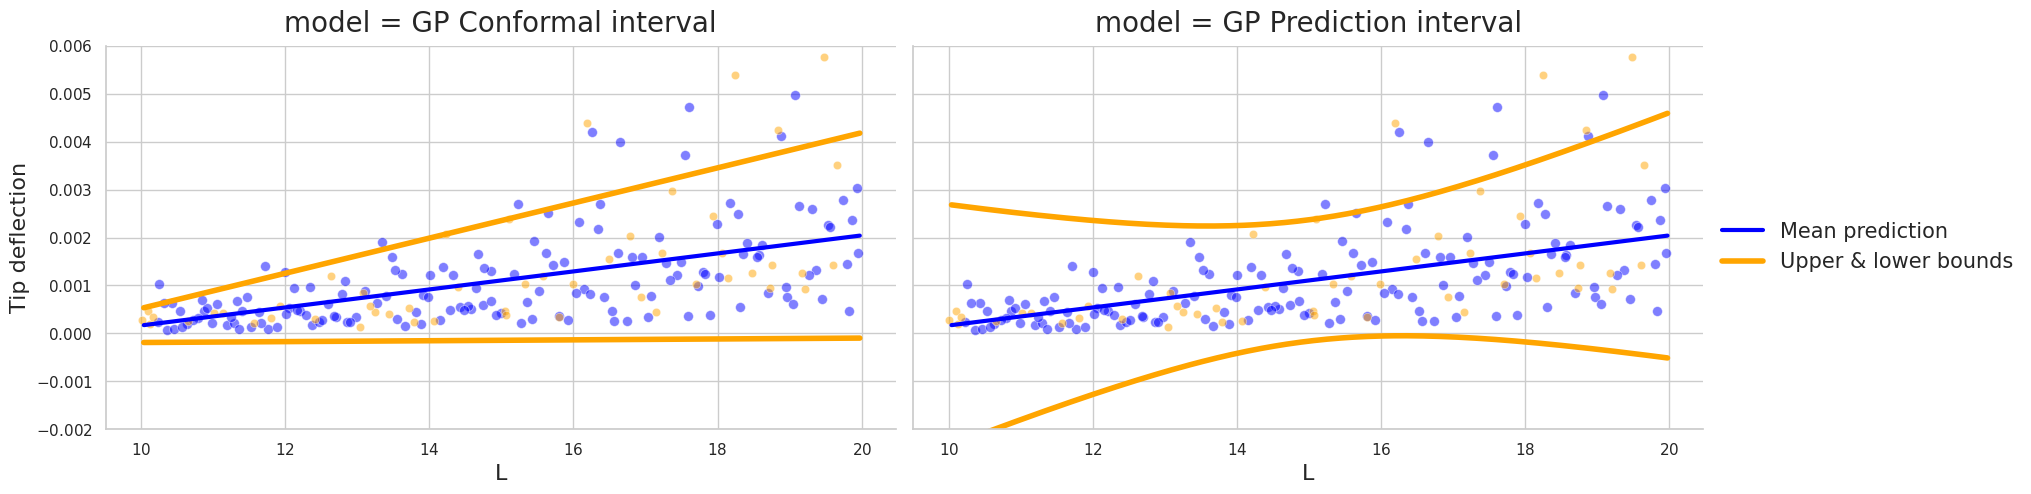

In [9]:
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": "cmr10",
        "axes.formatter.use_mathtext": True,
        "axes.titlepad": 10,
        "font.size": 1000,
        "axes.labelsize": 50,
        "axes.titlesize": 50,
    }
)
sns.set(style="whitegrid")
g = sns.FacetGrid(all_pred, col="model", height=5, aspect=1.75)
g.map(plt.plot, "x", ".pred", color="blue", lw=3)
g.map(plt.plot, "x", ".pred_lower", color="orange", lw=4)
g.map(plt.plot, "x", ".pred_upper", color="orange", lw=4)
for ax in g.axes.flat:
    sns.scatterplot(
        x=pretrain_data["x"], y=pretrain_data["y"], color="blue", s=50, alpha=0.5, ax=ax
    )
    sns.scatterplot(x=cal_data["x"], y=cal_data["y"], color="orange", alpha=0.5, ax=ax)
plt.ylim(-0.002, 0.006)
g.set_ylabels("Tip deflection", fontsize=16)  # Adjust the font size
g.set_xlabels("L", fontsize=16)  # Adjust the font size
g.add_legend(fontsize=15, labels=["Mean prediction", "Upper & lower bounds"])
for ax in g.axes.flat:
    ax.set_title(
        ax.get_title(), fontsize=20
    )  # Set the title font size to 20 (or adjust as needed)

plt.show()

# Towards more complex explainability vizualization and metrics 


/tmp/ipykernel_2580511/547070710.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  a.show()


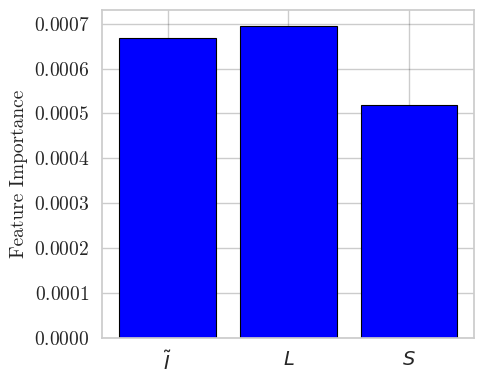

In [10]:
from smt.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt_ex.problems import MixedCantileverBeam
from smt.surrogate_models import KRG
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
import numpy as np
from smt.surrogate_models import KRG, MixIntKernelType

%matplotlib inline 

nsamples = 250
fun = MixedCantileverBeam()
ds = DesignSpace(
    [
        CategoricalVariable(values=[str(i + 1) for i in range(12)]),
        FloatVariable(10.0, 20.0),
        FloatVariable(1.0, 2.0),
    ]
)
x = fun.sample(nsamples)
y = fun(x)


# Index for categorical features
categorical_feature_indices = [0]

is_categorical = [False] * x.shape[1]
for feature_idx in categorical_feature_indices:
    is_categorical[feature_idx] = True

feature_names = [r"$\tilde{I}$", r"$L$", r"$S$"]
model = MixedIntegerKrigingModel(
    surrogate=KRG(
        design_space=ds,
        categorical_kernel=MixIntKernelType.GOWER,
        theta0=[1e-1],
        hyper_opt="Cobyla",
        corr="squar_exp",
        n_start=20,
        print_global=False,
    ),
)
model.set_training_values(x, np.array(y))
model.train()

x2 = fun.sample(nsamples * 3)

categorical_feature_indices = categorical_feature_indices
nsamples = nsamples
feature_names = feature_names
shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model,
    x2,
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    method="kernel",
)
a = shap_importance.plot()

a.show()
plt.show()

/tmp/ipykernel_2580511/1474065538.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  b.show()
/tmp/ipykernel_2580511/1474065538.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  c.show()
/tmp/ipykernel_2580511/1474065538.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  d.show()
/tmp/ipykernel_2580511/1474065538.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  e.show()
/tmp/ipykernel_2580511/1474065538.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
/tmp/ipykernel_2580511/1474065538.p

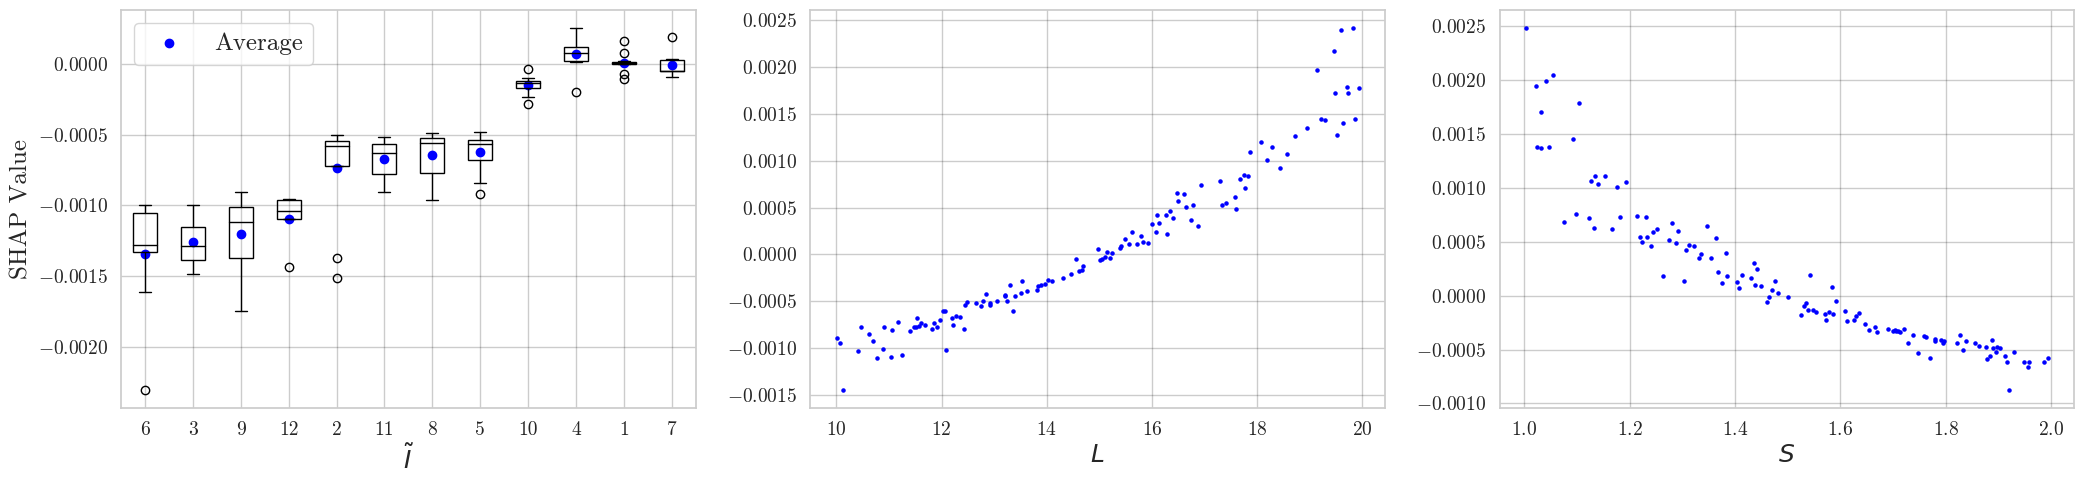

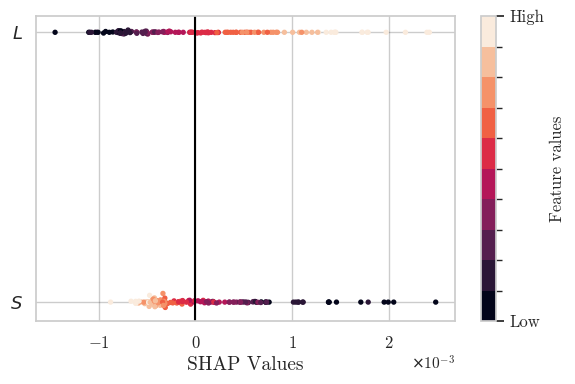

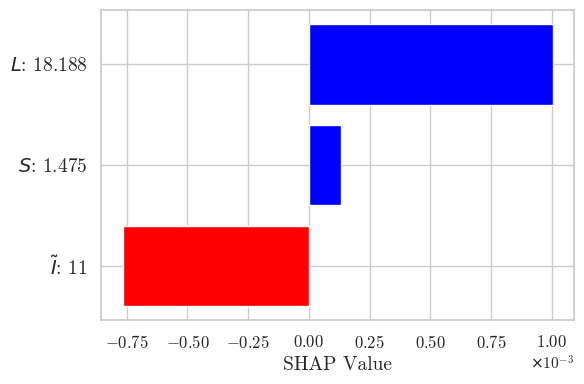

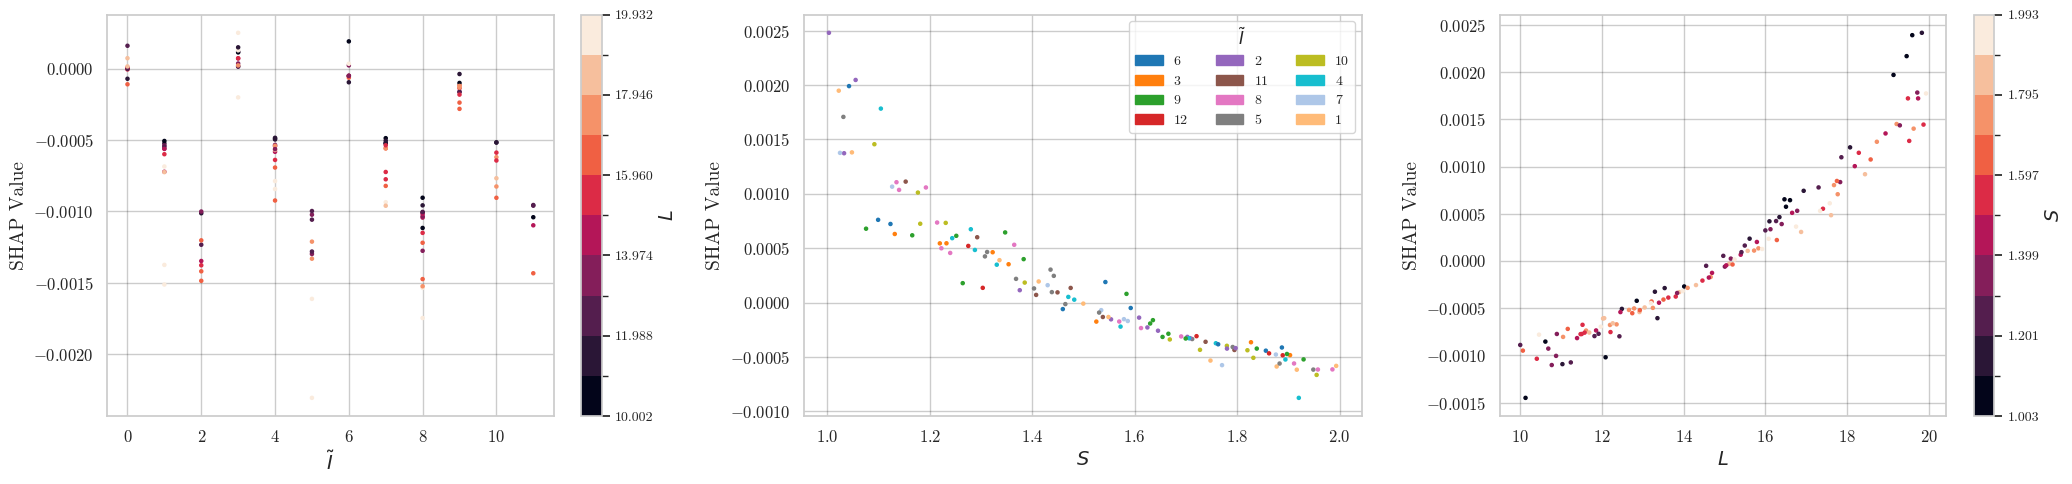

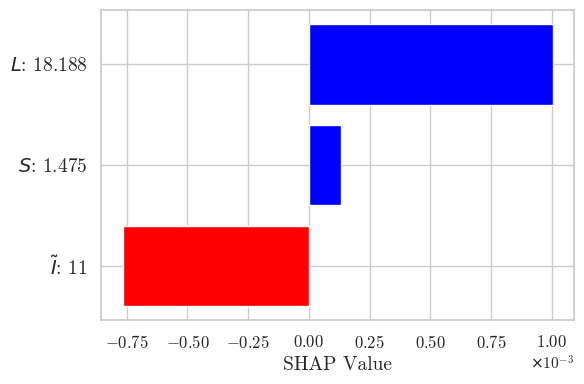

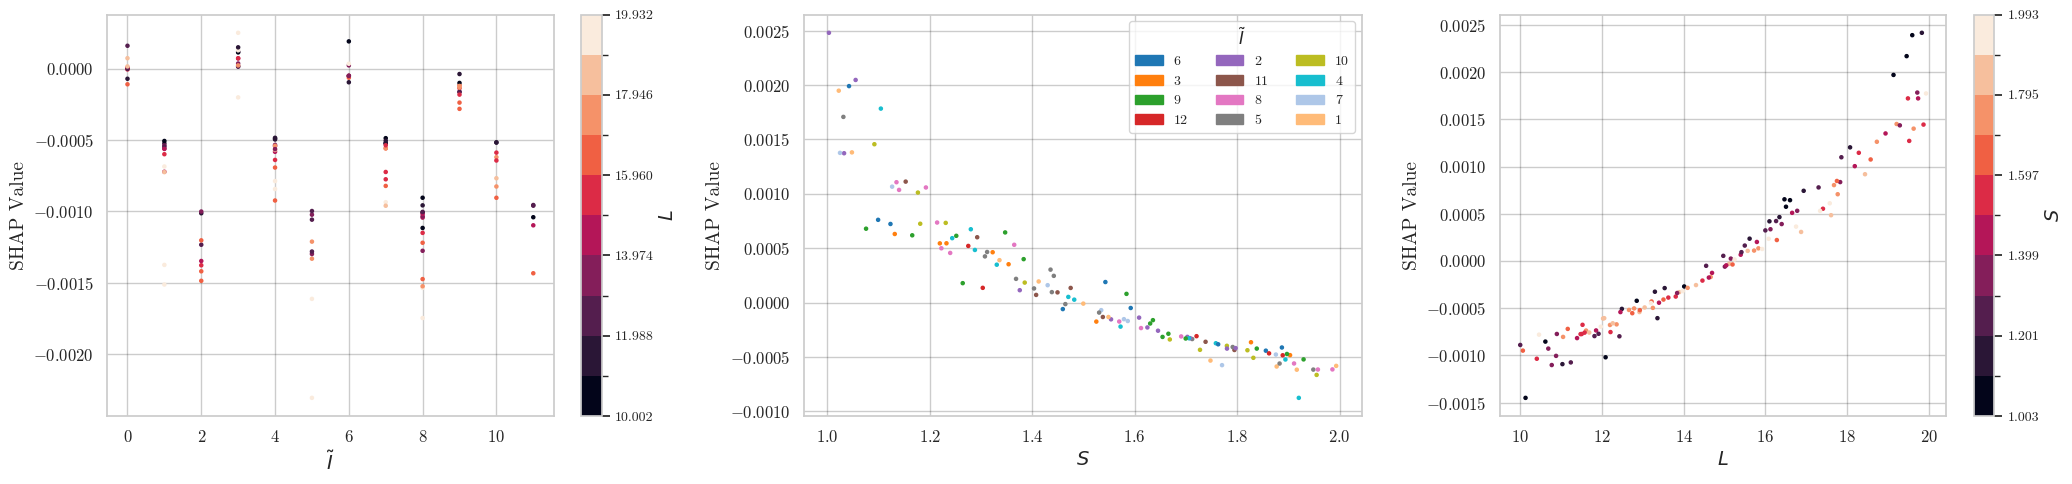

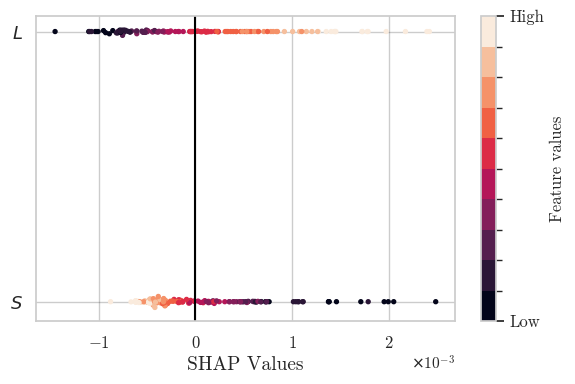

In [11]:
%matplotlib inline 

n_train = int(nsamples / 2)

x_tr, _y_tr = x[:n_train, :], y[:n_train]
x_te, _y_te = x[n_train:, :], y[n_train:]

# Index for categorical features
categorical_feature_indices = [0]
# create mapping for the categories
categories_map = dict()
is_categorical = [False] * x.shape[1]
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    is_categorical[feature_idx] = True

feature_names = [r"$\tilde{I}$", r"$L$", r"$S$"]


index_for_individual_plot = 0
feature_pairs_for_mixed_problem = [(0, 1), (2, 0), (1, 2)]

shap_explainer = ShapDisplay.from_surrogate_model(
    x_te,
    model,
    x_tr,
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    categories_map=categories_map,
    method="kernel",
)


b = shap_explainer.dependence_plot([0, 1, 2])

b.show()

c = shap_explainer.summary_plot()
c.show()

d = shap_explainer.individual_plot(index=index_for_individual_plot)
d.show()

e = shap_explainer.interaction_plot(feature_pairs_for_mixed_problem)
e.show()

f = shap_explainer.individual_plot(index=index_for_individual_plot)
f.show()

g = shap_explainer.interaction_plot(feature_pairs_for_mixed_problem)
g.show()
h = shap_explainer.summary_plot()
h.show()